In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, UpSampling2D, BatchNormalization, Reshape
from keras.layers import Dropout, Conv2DTranspose
from keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image
import keras.backend.tensorflow_backend as ktf
import tensorflow as tf
import os
import glob
import scipy.misc

Using TensorFlow backend.


In [0]:
def discriminator():
    
    net = Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4

    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(Activation('relu'))
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(Activation('relu'))
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(Activation('relu'))
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net


In [0]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(7*7*512, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    net.add(Reshape((7,7,512)))
    
    net.add(UpSampling2D())
    net.add(Conv2D(256, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(1, 1, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net


In [0]:
net_discriminator = discriminator()
net_generator = generator()

model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
opti = RMSprop(lr=0.00015)
model_discriminator.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
optim_adversarial = RMSprop(lr=0.00012)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

In [0]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models

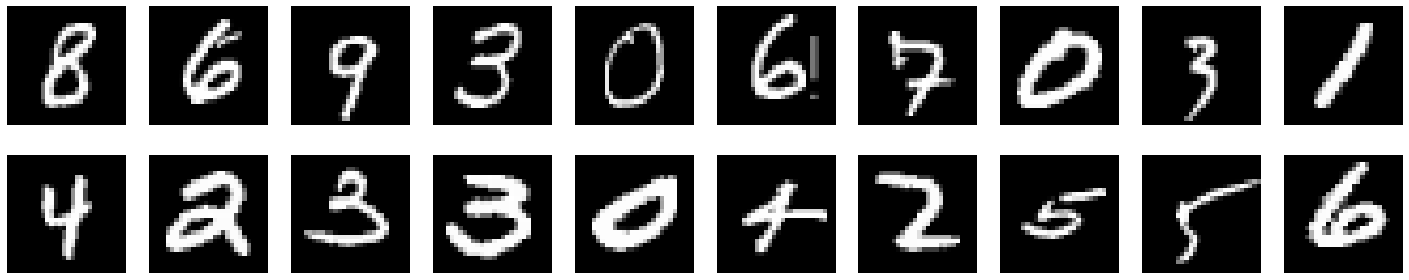

In [0]:
images = x_train[140:160]

plt.figure(figsize=(25,5))

for im in range(images.shape[0]):
    plt.subplot(2, 10, im+1)
    image = images[im, :, :, :]
    image = np.reshape(image, [28, 28])

    plt.imshow(image, cmap='gray')
    plt.axis('off')

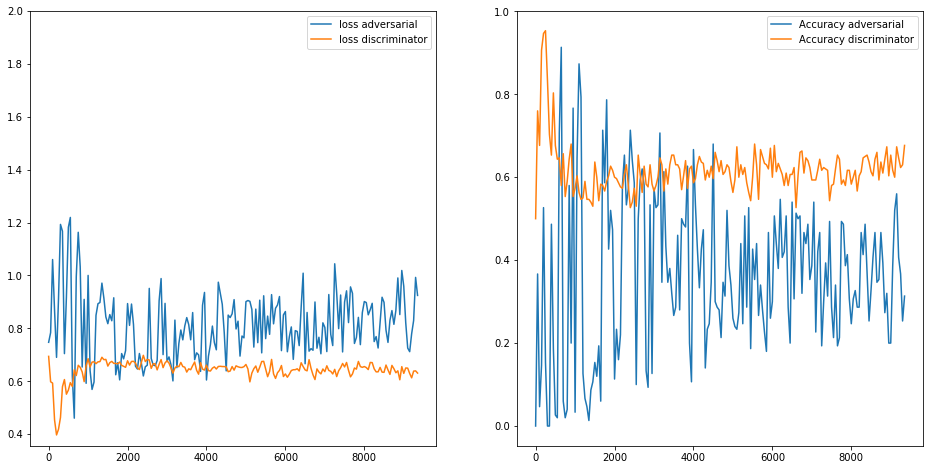

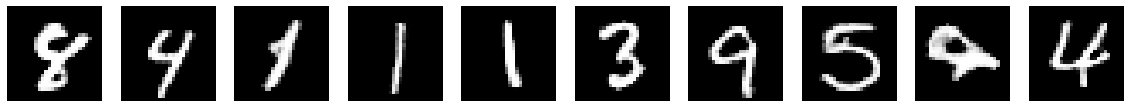

KeyboardInterrupt: ignored

In [0]:
batch_size = 150

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

test_noise = np.random.uniform(-1.0, 1.0, size=[10, 100])


for i in range(8001):

    images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = net_generator.predict(noise)

    # Create a dataset with fake and real images
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)

    # Train the generator
    # The input of th adversarial model is a list of noise vectors. The generator is 'good' if the discriminator classifies
    # all the generated samples as real. Therefore, the desired output is a list of all ones.
    y = np.ones([batch_size, 1])
    fake = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(fake, y)


    if i % 50 == 0:

        clear_output(wait=True)

        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax[0].plot(plot_iteration, loss_adv, label="loss adversarial")
        ax[0].plot(plot_iteration, loss_dis, label="loss discriminator")
        ax[0].legend()
        ax[0].set_ylim(top=2)

        ax[1].plot(plot_iteration, acc_adv, label="Accuracy adversarial")
        ax[1].plot(plot_iteration, acc_dis, label="Accuracy discriminator")
        ax[1].legend()
        
        test_samples = net_generator.predict(test_noise)
        
        
        plt.figure(figsize=(20,10))

        for im in range(test_samples.shape[0]):
            plt.subplot(1, 10, im+1)
            image = test_samples[im, :, :, :]
            image = np.reshape(image, [28, 28])

            plt.imshow(image, cmap='gray')
            plt.axis('off')
        


        plt.show()
